In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

from pathlib import Path
import nibabel as nib

from utils.plot import *
from utils.degrade import *
from utils.filter_bank_utils import *
from tqdm import tqdm

set_display_mode('dark')
device = device = torch.device(f'cuda:1')

In [205]:
from scipy import signal

In [206]:
def bandpass_firwin(ntaps, lowcut, highcut, fs, window='hamming'):
    taps = signal.firwin(ntaps, [lowcut, highcut], fs=fs, pass_zero='bandpass',
                  window=window, scale=False)
    return taps

In [583]:
def fourier_mag(x):
    return np.abs(np.fft.fftshift(np.fft.fft(x)))

In [563]:
gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

Testing some filter bank util functions. Can we do a filter bank without filters?

In [564]:
x = vol_to_batch(gt_vol)

In [565]:
c = x[:, ::2]

In [566]:
d = advance(x, 1)[:, ::2]

In [567]:
x_hat = upsample_m(c, 2) + delay(upsample_m(d, 2), 1)

TypeError: Cannot interpret 'torch.float32' as a data type

In [568]:
(x == x_hat).all()

tensor(False)

# Testing filter bank with filters

In [1094]:
# Simulate slice gap with a strided convolution.
# In this case, we use our 1mm FWHM Gaussian
fwhm = 4
h0 = select_kernel(21, window_choice='gaussian', fwhm=fwhm, sym=True).astype(np.float32)
h0 /= h0.sum()

In [1095]:
# h0_up = upsample_m(h0[np.newaxis, ...], fwhm*2)[0]
h0_up = resize(h0, dxyz=(1/(fwhm),), order=5)
# h0_up /= fwhm*2
h0_up /= h0_up.sum()

# pad to the same array size
pads = (int(np.abs(h0.shape[0] - h0_up.shape[0]) // 2), 
        int(np.abs(h0.shape[0] - h0_up.shape[0]) // 2)+1)
h0 = np.pad(h0, pads)

In [1096]:
h0.shape, h0_up.shape

((84,), (84,))

In [1097]:
plt.plot(h0, color='magenta', label='h0')
plt.plot(h0_up, color='cyan', label='h0_up')
plt.legend()
plt.show()

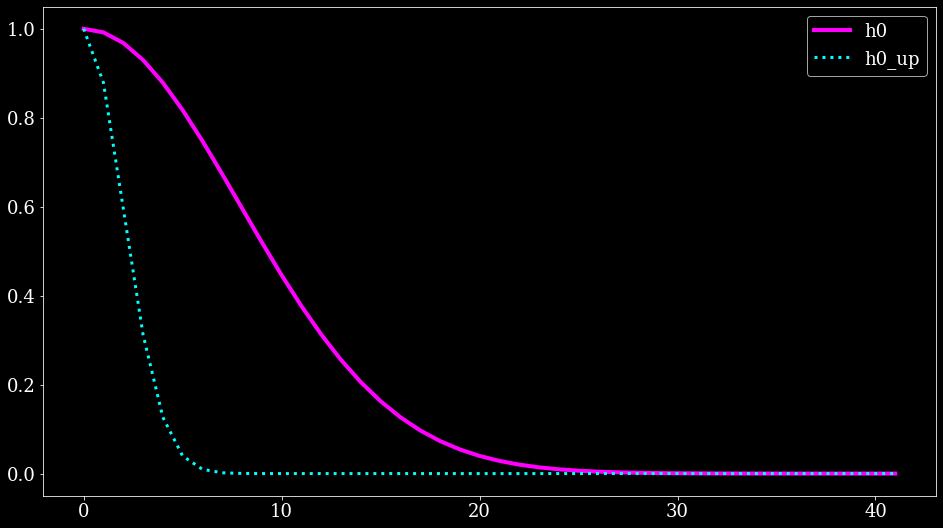

In [1098]:
# plt.plot(h1)
# plt.show()
plt.plot(fourier_mag(h0)[len(h0)//2:], color='magenta', label='h0', linewidth=4, linestyle='-')
plt.plot(fourier_mag(h0_up)[len(h0_up)//2:], color='cyan', label='h0_up', linewidth=3, linestyle=':')
plt.legend()
plt.show()

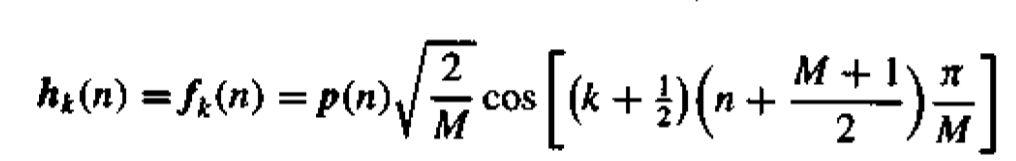

In [1229]:
np.sinc?

In [1351]:
# shift by multiplying by a complex exponential

# k = 5
# M = 5
# n = np.linspace(0, np.pi, len(h0))
# cosine_wave = np.sqrt(2/M) * np.cos((k + 1/2) * (n + (M+1)/2) * (np.pi / M))

L = 101
h0 = select_kernel(L, window_choice='gaussian', fwhm=4, sym=True).astype(np.float32)

t = np.linspace(0, 2*np.pi, len(h0))
M = 4

filters = []

for k in range(0, M+1):
    f = -k / M / 2 * L
    omega = 2 * np.pi * f
    complex_exponential = np.exp(-1j * omega * t)
    
    h_k = h0 * complex_exponential
    
    filters.append(h_k)

In [1352]:
# colors = ['magenta', 'cyan', 'yellow', 'lime', 'red']
colors = plt.cm.rainbow(np.linspace(0, 1, M))
for i, (h, color) in enumerate(zip(filters, colors)):
    L = len(h)
    H = fourier_mag(h)[L//2:]
    
    plt.plot(np.linspace(0, 2*np.pi, len(H)), 20 * np.log10(H), color=color)
#     plt.plot(fourier_mag(h), color=color, label=f'h{i}', linewidth=4)

# plt.legend()
plt.show()

In [1285]:
fc = 0.2  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
N = 25    # Number of coefficients.
L = 1024  # Length of frequency response.
 
# Compute sinc filter with Hamming window.
n = np.arange(N)
h = np.sinc(2 * fc * (n - (N - 1) / 2)) * np.hamming(N)
h /= np.sum(h)

# shift
k = 5
M = 5
f = k / M / 2
omega = 2 * np.pi * f
complex_exponential = np.exp(-1j * omega * n)
h = (h * complex_exponential).real
 
# Pad filter with zeros.
h_padded = np.zeros(L)
h_padded[0 : N] = h

 
# Compute frequency response; only keep first half.
H = np.abs(np.fft.fft(h_padded))[0 : L // 2 + 1]
 
# Plot frequency response (in dB).
plt.figure()
plt.plot(np.linspace(0, 0.5, len(H)), 20 * np.log10(H))
plt.xlabel('Normalized frequency')
plt.ylabel('Gain [dB]')
plt.ylim([-100, 10])
plt.grid()
plt.show()

In [1064]:
plt.plot(complex_exponential.real)

In [1065]:
h0_shift = h0_up * complex_exponential
# h0_shift /= h0_shift.sum()

In [1066]:
plt.plot(h0_shift.real)

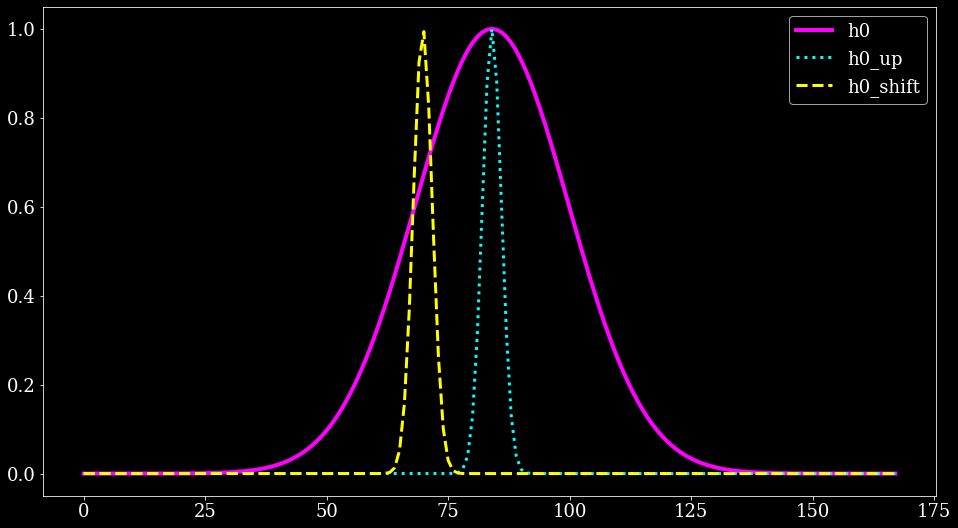

In [1067]:
# plt.plot(h1)
# plt.show()
plt.plot(fourier_mag(h0), color='magenta', label='h0', linewidth=4, linestyle='-')
plt.plot(fourier_mag(h0_up), color='cyan', label='h0_up', linewidth=3, linestyle=':')
plt.plot(fourier_mag(h0_shift), color='yellow', label='h0_shift', linewidth=3, linestyle='--')

plt.legend()
plt.show()

In [1034]:
p = h0
filters = []#[p]

M = 4
n = np.linspace(0, np.pi, len(p))

for k in range(0, M):
#     cosine_wave = np.sqrt(2/M) * np.cos((k + 1/2) * (n + (M+1)/2) * (np.pi / M))
    
    h_k = p * cosine_wave
    h_k /= np.abs(np.sum(h_k))
    filters.append(h_k)

In [1038]:
filters[2].sum()

-0.9999999999999998

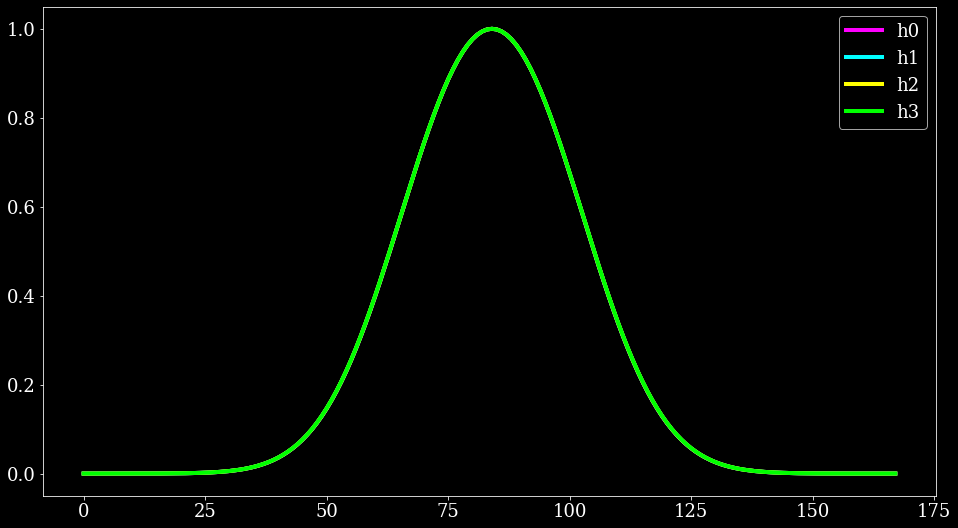

In [1039]:
colors = ['magenta', 'cyan', 'yellow', 'lime']

for i, (h, color) in enumerate(zip(filters, colors)):
    plt.plot(fourier_mag(h), color=color, label=f'h{i}', linewidth=4)

plt.legend()
plt.show()

# TODO: think about how to design the synthesis filters better. What are they supposed to do?

In [386]:
# can we multiply by a sinusoid to apply a shift and rescaling in frequency?
# Ideally, for high pass filters we want to shrink by M-1 and then shift appropriately

In [387]:
# h1 = bandpass_firwin(ntaps=21, lowcut=0.5, highcut=0.999, fs=2).astype(np.float32)

cos_arr = np.cos(np.linspace(0, np.pi, 21))
cos_arr

array([ 1.00000000e+00,  9.87688341e-01,  9.51056516e-01,  8.91006524e-01,
        8.09016994e-01,  7.07106781e-01,  5.87785252e-01,  4.53990500e-01,
        3.09016994e-01,  1.56434465e-01,  6.12323400e-17, -1.56434465e-01,
       -3.09016994e-01, -4.53990500e-01, -5.87785252e-01, -7.07106781e-01,
       -8.09016994e-01, -8.91006524e-01, -9.51056516e-01, -9.87688341e-01,
       -1.00000000e+00])

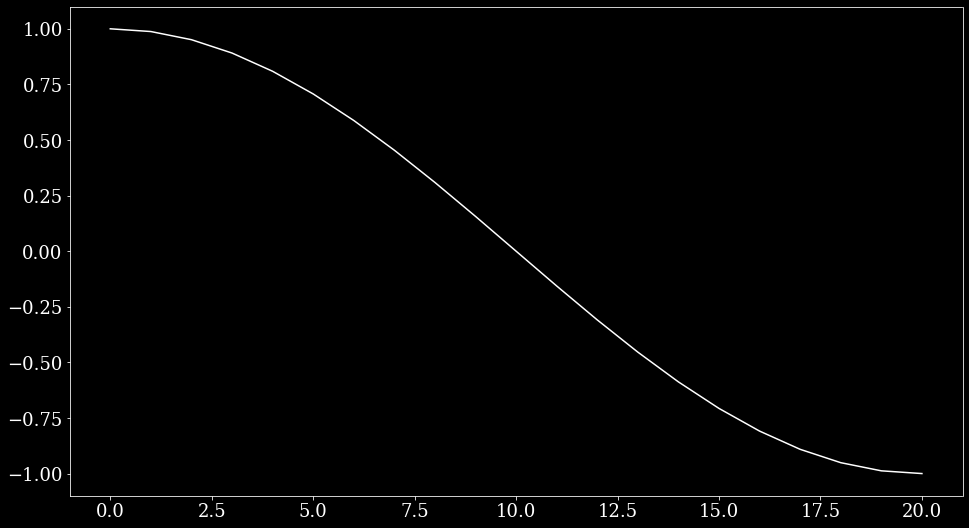

In [388]:
plt.plot(cos_arr)

In [392]:
# h1 = torch.from_numpy(get_h1(h0))
# f0 = torch.from_numpy(get_f0(h0))
# f1 = torch.from_numpy(get_f1(h0))
# h0 = torch.from_numpy(h0)

alt = np.array([(-1)**i for i in range(len(h0))]).astype(np.float32)

f0 = h0
f1 = h1

h0 = torch.from_numpy(h0)
h1 = torch.from_numpy(h1)
f0 = torch.from_numpy(f0)
f1 = torch.from_numpy(f1)

TypeError: expected np.ndarray (got Tensor)

In [226]:
c = downsample_m(apply_filter(x, h0), 2)

In [227]:
d = downsample_m(apply_filter(advance(x, 1), h1), 2)

In [228]:
x_hat = apply_filter(upsample_m(c, 2), f0) + \
    delay(apply_filter(upsample_m(d, 2), f1), 1)

In [229]:
x_vol = batch_to_vol(x, D=256)
x_hat_vol = batch_to_vol(x_hat, D=256)

In [230]:
abs_diff_vol = np.abs(x_vol - x_hat_vol)

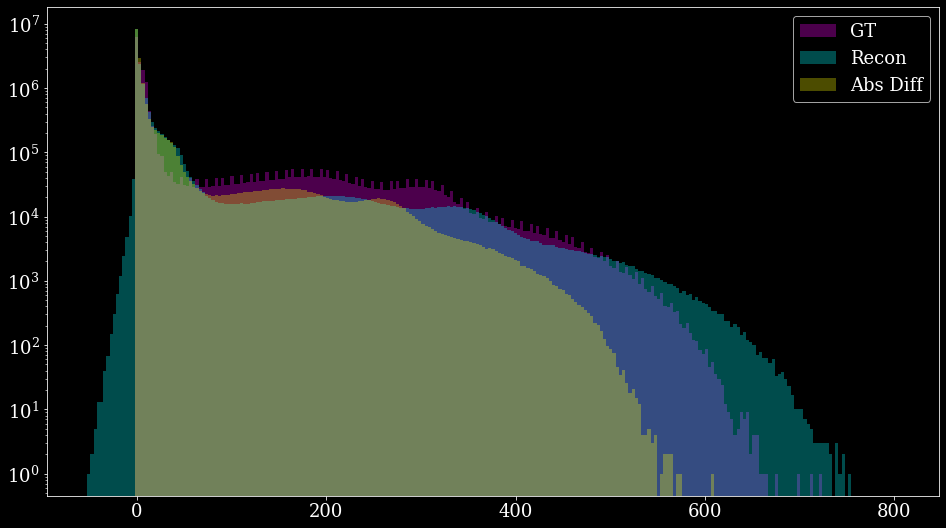

In [231]:
n_bins = 256
bins = np.round(np.linspace(
        min(x_vol.min(), x_hat_vol.min(), abs_diff_vol.min()),
        max(x_vol.max(), x_hat_vol.max(), abs_diff_vol.max()), 
        n_bins), 4)

plt.hist(x_vol.flatten(), bins=bins, label='GT', color='magenta', alpha=0.3)
plt.hist(x_hat_vol.flatten(), bins=bins, label='Recon', color='cyan', alpha=0.3)
plt.hist(abs_diff_vol.flatten(), bins=bins, label='Abs Diff', color='yellow', alpha=0.3)
plt.yscale('log')
plt.legend()
plt.show()

In [232]:
from skimage.metrics import peak_signal_noise_ratio

In [233]:
data_range = x_vol.max() - x_vol.min()

In [234]:
peak_signal_noise_ratio(x_vol, x_hat_vol, data_range=data_range)

20.967019715854637

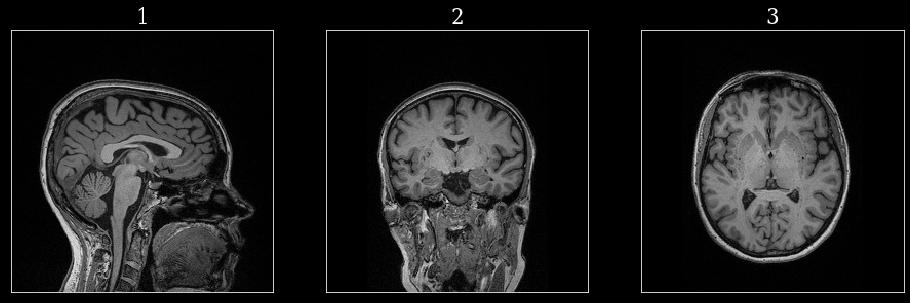

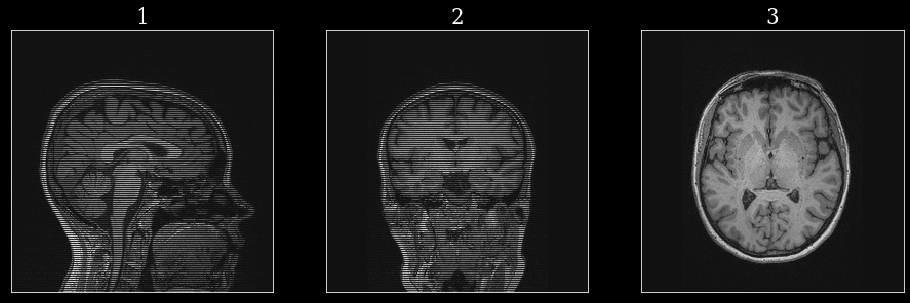

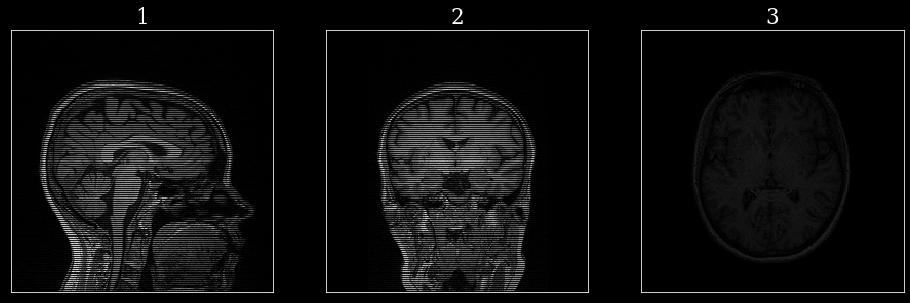

In [235]:
center_vol_plot(x_vol)
center_vol_plot(x_hat_vol)
center_vol_plot(abs_diff_vol)

In [ ]:
lr_vol = torch.nn.functional.conv1d(
    torch.from_numpy(gt_vol).flatten(start_dim=0, end_dim=1).unsqueeze(1), 
    torch.from_numpy(h0).unsqueeze(0).unsqueeze(1), 
    stride=2, 
    padding=h0.shape[0]//2,
)
lr_vol = lr_vol.reshape(256, 256, lr_vol.shape[2])

In [ ]:
lr_vol.shape

In [ ]:
center_vol_plot(
    lr_vol.numpy(),
    (256, 256, 256)
)

In [ ]:
# for a FWHM of 1, a slice gap of 1 results in a stride of 2
# we can model this with a 2-channel filter bank
# we model arbitrary strides M as an M-channel filter bank

In [ ]:
# calculate h_1, f_0, f_1 from h_0, our slice profile

In [ ]:
h1 = get_h1(h0)
f0 = get_f0(h0)
f1 = get_f1(h0)

In [ ]:
h0

In [ ]:
h1

In [ ]:
# plot frequency response
L = len(h0)
h0_freq_response = np.abs(np.fft.fft(h0)).squeeze()[0 : L // 2 + 1]
h1_freq_response = np.abs(np.fft.fft(h1)).squeeze()[0 : L // 2 + 1]

In [ ]:
plt.plot(np.linspace(0, 0.5, len(h0_freq_response)), 20 * np.log10(h0_freq_response),
         color='magenta', label='LPF')
plt.plot(np.linspace(0, 0.5, len(h1_freq_response)), 20 * np.log10(h1_freq_response),
         color='cyan', label='HPF')

plt.xlabel('Normalized frequency')
plt.ylabel('Gain [dB]')
plt.grid()
plt.legend()
plt.show()

Our job is to regress the detail coefficients; we then reconstruct with filter bank theory
To test, we'll get those detail coefficients directly from the ground truth

In [ ]:
# Note that we have to advance by 1
details = torch.nn.functional.conv1d(
    torch.nn.functional.pad(
        torch.from_numpy(gt_vol[:, :, 1:]), (0, 1), mode='constant', value=0.0)\
    .flatten(start_dim=0, end_dim=1).unsqueeze(1), 
    torch.from_numpy(h1).unsqueeze(0).unsqueeze(1), 
    stride=2, 
    padding=h1.shape[0]//2,
)
details = details.reshape(256, 256, details.shape[2])

In [ ]:
center_vol_plot(details)

In [ ]:
# reconstruction
# upsample by inserting zeros
lr_flat = lr_vol.flatten(start_dim=0, end_dim=1)
up_coarse = torch.zeros((lr_flat.shape[0], 2*lr_flat.shape[1]), dtype=torch.float32)
up_coarse[:, ::2] = lr_flat
up_coarse = up_coarse.reshape(lr_vol.shape[0], lr_vol.shape[1], up_coarse.shape[1])

In [ ]:
center_vol_plot(up_coarse)

In [ ]:
details_flat = details.flatten(start_dim=0, end_dim=1)
up_details = torch.zeros((details_flat.shape[0], 2*details_flat.shape[1]), dtype=torch.float32)
up_details[:, ::2] = details_flat
up_details = up_details.reshape(details.shape[0], details.shape[1], up_details.shape[1])

In [ ]:
center_vol_plot(up_details)

In [ ]:
# filter and add
up_coarse_filtered = torch.nn.functional.conv1d(
    up_coarse.flatten(start_dim=0, end_dim=1).unsqueeze(1), 
    torch.from_numpy(f0).unsqueeze(0).unsqueeze(1), 
    stride=1, 
    padding=f0.shape[0]//2,
)
up_coarse_filtered = up_coarse_filtered.reshape(256, 256, up_coarse_filtered.shape[2])

up_details_filtered = torch.nn.functional.conv1d(
    up_details.flatten(start_dim=0, end_dim=1).unsqueeze(1), 
    torch.from_numpy(f1).unsqueeze(0).unsqueeze(1), 
    stride=1, 
    padding=f0.shape[0]//2,
)
up_details_filtered = up_details_filtered.reshape(256, 256, up_details_filtered.shape[2])

In [ ]:
# before sum, we delay the details
recon = up_coarse_filtered + \
    torch.nn.functional.pad(up_details_filtered[:, :, :-1], (1, 0), mode='constant', value=0.0)

In [ ]:
center_vol_plot(recon)

In [ ]:
recon_img = recon[128].numpy()
gt_img = gt_vol[128]
abs_diff = np.abs(recon_img - gt_img)

In [ ]:
multiplot([recon_img, gt_img, abs_diff], ["Recon", "GT", "Abs Diff"])

In [ ]:
abs_diff.max()

In [ ]:
padded_array = np.zeros(2*len(original_list)-1, dtype=original_array.dtype)
padded_array[::2] = original_array

In [ ]:
up_coarse.shape

In [ ]:
lr_flat.shape

In [ ]:
np.insert?